# Cleaner version of MNIST using Jax, Flax and Netket

## 0 - Install Requirements

For this example notebook we will need jax+flax+optax for the machine-learning part.

For the dataset, instead, we will be using `tensorflow_datasets`, which is a submodule of `tensorflow` that makes it easy to download and load into memory large datasets (such as MNIST and many others).

If you are running notebook locally, you need to also install `tensorflow` to make `tensorflow_datasets` work.

In [1]:
# Requirements
!pip install tensorflow_datasets flax jax optax tqdm netket imgaug==0.2.6

You should consider upgrading via the 'pip install --upgrade pip' command.


## 1 - Setting up the dataset
First of all, we need to download the dataset.

The MNIST dataset is a standard dataset composed of several 28x28 black/white images representing numbers, and a label corresponding to the number that is represented there.

In [2]:
from utils import *

/Users/theresatratzmuller/Documents/Code.nosync/ws21_22/ml/ml_env/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


Load the dataset, normalize it, convert it to floating point (? hope Fabrizio's minmax-normalization actually does this), split into train and test.

In [3]:
train_ds, test_ds = get_data()

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Visualize

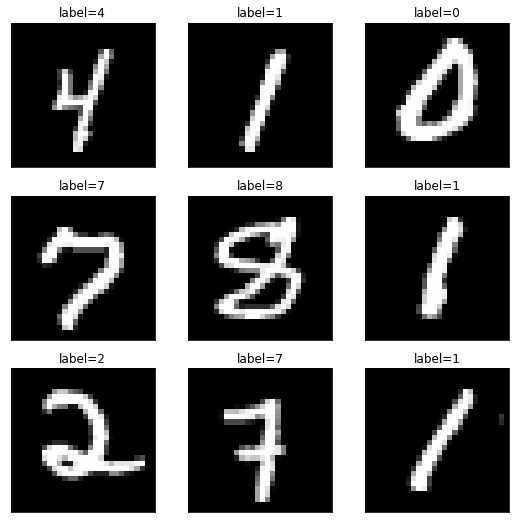

In [4]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(9)],
    [f'label={train_ds["label"][idx]}' for idx in range(9)],
)

## 2 - The model (Neural Network)

We want now to define the Model.
We will use Flax to do that.

We want our network to return a probability distribution for the input to correspond to one of several output labels.

e.g: if $x$ is an image, then $f : \mathbb{R}^{28\times 28}\rightarrow \mathbb{R}^{10}$ and $f^{(i)}(x)$ is the probability that the image $x$ represents a $i\in[0,9]$

To make the output of the network a probability distribution, we can use a softmax function, defined as

$$
\sigma_i(x) = \frac{e^{x_i}}{\sum_i^K e^{x_i} }  \text{   for  } i\in [1,K] \text{ and } x\in\mathbb{R}^K
$$

We want to use a Feedforward network with 2 Dense Layers, relu-nonlinearity and output softmax using Flax.


***NOTE*** (to myself and whoever else may be interested in this information): we use softmax rather than argmax when training a NN because the argmax wouldn't work with backpropagation (zero derivatives!)

In [5]:
import jax
import jax.numpy as jnp

# We import flax.linen as nn
# The reason is that flax.nn is old and deprecated and will be removed one day
import jax
import flax

# From now on, use netket as nk wherever the original notebook uses flax.linen as nn!
import netket as nk
import jax.numpy as jnp

from jax.experimental import stax

Activation originally suggested by Carleo: modRelu.

In [6]:
def modRelu(z, bias): # relu(|z|+b) * (z / |z|)
    norm = jnp.abs(z)
    scale = nk.nn.relu(norm + bias) / (norm + 1e-6)
    scaled = jax.lax.complex(jnp.real(z)*scale, jnp.imag(z)*scale)
    return scaled
modRelu=jax.jit(modRelu)

New activation function suggestion by Dian:

In [7]:
def complex_relu(z):
    return jnp.where(z.real > 0, z, 0)

In [8]:
# Same model as above but complex

class Model(nk.nn.Module):
  n_classes : int = 10
  @nk.nn.compact
  # Provide a constructor to register a new parameter 
  # and return its initial value
  def __call__(self, x):
    #dropout_rng = self.make_rng('dropout')

    x = nk.nn.Conv(features=32, kernel_size=(3, 3), dtype=complex)(x)

    # bias1 = self.param('bias1', jax.nn.initializers.zeros, (28,28,32))
    # x = modRelu(x, bias1)

    x = complex_relu(x)

    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2)) 
    
    x = nk.nn.Conv(features=64, kernel_size=(3, 3), dtype=complex)(x)
    #x = flax.linen.Dropout(0.5, deterministic=True)(x) #DROPOUT 1

    # bias2 = self.param('bias2', jax.nn.initializers.zeros, (14,14,64))
    # x = x = modRelu(x, bias2)
    x = complex_relu(x)

    x = flax.linen.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1)) # Flatten
    x = nk.nn.Dense(features=256, dtype=complex)(x)

    # bias3 = self.param('bias3', jax.nn.initializers.zeros, 256)
    # x = x = modRelu(x, bias3)
    x = complex_relu(x)

    #x = flax.linen.Dropout(0.5, deterministic=True)(x) # DROPOUT 2

    x = nk.nn.Dense(features=10, dtype=complex)(x)    # There are 10 classes in MNIST

    x = jnp.abs(x) #<= I guess this isn't required anymore?
    # x = nk.nn.softmax(x)

    # In the Jax tutorial, log_softmax is used - should we use it too?
    # => let's try
    x = nk.nn.log_softmax(x)

    return x


Set this model as a global variable too.

In [9]:
set_model(Model)

## 3 - set up randomness generators, hyperparameters, optimiser

Initialize the train state, using seed randomness (I copied this from the [flax documentation](https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html))

In [10]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [ ]:
dropout_rng, init_dropout = jax.random.split(jax.random.PRNGKey(1))

In [11]:
learning_rate = 0.1
momentum = 0.9

In [12]:
import optax

# Construct the optimiser
# we use optimisers from the optax package which is a very comprehensive
# optimiser library
optimiser = optax.sgd(learning_rate, momentum)

## 4 - create the initial state

In [14]:
state = create_train_state(init_rng, optimiser, init_dropout)
del init_rng  # Must not be used anymore.

## 5 - define the loss function

In [15]:
# The loss function that we will use
def cross_entropy(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

In [16]:
set_loss_fn(cross_entropy)

## 6 - do the actual training

In [17]:
# Import the TQDM progress bar module using automatic notebook detection
# Otherwise it would not work..
from tqdm.auto import tqdm

num_epochs = 10

batch_size = 32

metrics = {"test_loss" : [], "test_accuracy": [], "train_loss":[], "train_accuracy":[]}

with tqdm(range(1, num_epochs + 1)) as pbar:
    for epoch in pbar:
        # Use a separate PRNG key to permute image data during shuffling
        rng, input_rng = jax.random.split(rng)
        # dropout_rng, _ = jax.random.split(dropout_rng)
        # Run an optimization step over a training batch
        state, train_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng, dropout_rng)
        
        # Evaluate on the test set after each training epoch
        test_loss, test_accuracy = evaluate_model(state.params, test_ds)
        pbar.write('train epoch: %d, loss: %.4f, accuracy: %.2f' % (epoch, train_metrics['loss'], train_metrics['accuracy'] * 100))
        pbar.write(' test epoch: %d, loss: %.2f, accuracy: %.2f' % (epoch, test_loss, test_accuracy * 100))

        # save data
        metrics["train_loss"].append(train_metrics["loss"])
        metrics["train_accuracy"].append(train_metrics["accuracy"])
        metrics["test_loss"].append(test_loss)
        metrics["test_accuracy"].append(test_accuracy)

    

  0%|          | 0/10 [12:26<?, ?it/s]


KeyboardInterrupt: 

## 7 - check performance

We now want to check the performance of the model

Text(0, 0.5, 'Accuracy')

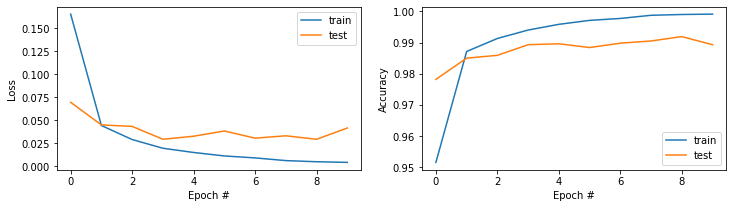

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12,3))

axs[0].plot(metrics["train_loss"], label="train")
axs[0].plot(metrics["test_loss"], label="test")
axs[0].legend()
axs[0].set_xlabel("Epoch #")
axs[0].set_ylabel("Loss")


axs[1].plot(metrics["train_accuracy"], label="train")
axs[1].plot(metrics["test_accuracy"], label="test")
axs[1].legend()
axs[1].set_xlabel("Epoch #")
axs[1].set_ylabel("Accuracy")